# Transformations
In the final part of this lesson, we will discuss variable transformations. These can be applied either to the *outcome* variable or to the *predictor* variables and can be used for a variety of reasons. Often, transformations are employed so that the model fits better or to correct for violations of certain assumptions. Other times, transformations can be used to help the interpretation of the model. In this part of the lesson, we will discuss methods of transformation for all these purposes as well as providing advice for choosing suitable transformations.

## Transforming the Outcome
We will start by looking at transforming the outcome variable. Typically, these transformations concern improving the model fit, but can also be used to improve the model assumptions, given that any transformation applied to the outcome will be carried into a transformation of the residuals. However, we need to be clear about the types of transformations we apply to the data. Typically, we only want to consider transformations that are *monotonic*. This means that the order of the data is preserved. One example would be taking $\log y_{i}$, as the data will remain in the same order. However, an example of a *non-monotonic* transformation would be the absolute value $|y_{i}|$ because if there are *negative* measures of $y$ they will be made *positive* and the data order will change. A similar situation happens with negative values and $y^{2}$. In general, we need to only consider those transformations that are *scaling* our data, nothing more. 

### Box-Cox Transformations
Although we are restricting ourselves to monotonic transformations, that still leaves a wide array of possible approaches. For instance, all the following are potential monotonic transformations:

- Addition/Subtraction of a constant
- Multiplication/Division by a positive constant
- Exponents with a positive base
- Logarithmic transformations
- Square-Root transformation
- Arcsine transformation

Given that there are a wide variety of possible transformations, we could simply guess and try lots of different transformations to see what happens. This is a perfectly acceptable approach, though it is neither very principled nor efficient. We could also look for guidelines on what transformations are best for reducing properties such as skew or extreme values. This is a bit more principled, but is still not particularly efficient. 

A much better method was given by [Box & Cox (1964)](http://www.econ.illinois.edu/~econ508/Papers/boxcox64.pdf). Here, transformations of the form $y^{\lambda}$ are considered. When $\lambda \neq 0$ this is a simple power transformation and when $\lambda = 0$ this is defined as $\log y$. This format then encompasses a wide-range of possible transformations. For instance 

| $\lambda$ value   | Transformation        | Equivalent Expression   |
|-------------------|-----------------------|--------------------------|
| 2                 | $y^{2}$               | $y^{2}$                  |
| 1                 | $y^{1}$               | $y$                      |
| 0.5               | $y^{1/2}$             | $\sqrt{y}$               |
| 0.33              | $y^{1/3}$             | $\sqrt[3]{y}$            |
| 0                 | $\log(y)$             | $\log_{e}(y)$            |
| -0.5              | $y^{-1/2}$            | $\frac{1}{\sqrt{y}}$     |
| -1                | $y^{-1}$              | $\frac{1}{y}$            |

The utility of this method is that the value of $\lambda$ that makes the data most probable can be found using maximum likelihood. This means that rather than searching through lots of possible transformations, we can just run the Box-Cox method and then evaluate whether a transform seems necessary. Of note, however, is that

- Box-Cox is only defined for $y > 0$. If the data has negative or 0 values, it will need to first be offset by adding a constant to make all values greater than 0.
- The value of $\lambda$ returned can be anything, which can make the transformed data hard to interpret. If the returned value is close to a more intepretable transformation, you may wish to choose that instead.
- Box-Cox is sensitive to outliers, so if you get very large estimated values of $\lambda$ (such as $\hat{\lambda} = 5$), then this is likely the reason. Extreme transformations are almost never warranted.

As an example, we can use the `boxcox()` function from the `MASS` package on our model of `mpg`

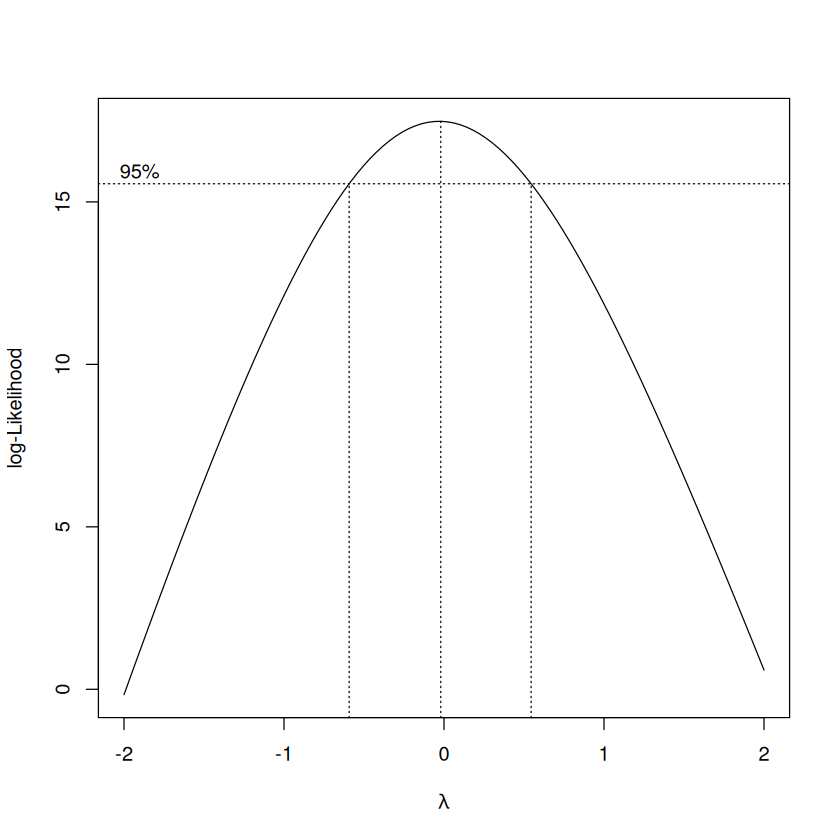

In [1]:
library(MASS)
data(mtcars)
mod <- lm(mpg ~ wt + hp + cyl, data=mtcars)
box <- boxcox(mod)

The plot shows all the values of $\lambda$ that were considered along the $x$-axis and a plot of the log-likelihood along the $y$-axis. We can see that the value that maximises the likelihood is very close to 0, and so we may want to consider a simple log-transformation. If we want to know the precise value of $\hat{\lambda}$ here, we can use

In [2]:
lik      <- box$y
lam      <- box$x 
best.lam <- lam[lik == max(lik)]
print(best.lam)

[1] -0.02020202


We could include this in the regression model by using the formula `I(mpg^best.lam) ~ wt + hp + cy`, however, this is equivalent to the transformation $\frac{1}{\text{MPG}^{0.02}}$, which is not very interpretable. Given that this is very close to $\hat{\lambda} = 0$, we would choose the log-transformation instead. We try this below

In [3]:
log.mod <- lm(log(mpg) ~ wt + hp + cyl, data=mtcars)
summary(log.mod)


Call:
lm(formula = log(mpg) ~ wt + hp + cyl, data = mtcars)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.14769 -0.07440 -0.02094  0.06940  0.25102 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.8846131  0.0778794  49.880  < 2e-16 ***
wt          -0.1746533  0.0322776  -5.411 9.03e-06 ***
hp          -0.0010434  0.0005176  -2.016   0.0535 .  
cyl         -0.0342858  0.0240114  -1.428   0.1644    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1095 on 28 degrees of freedom
Multiple R-squared:  0.8779,	Adjusted R-squared:  0.8649 
F-statistic: 67.13 on 3 and 28 DF,  p-value: 6.647e-13


We can then create the assumptions plots from the *untransformed* model

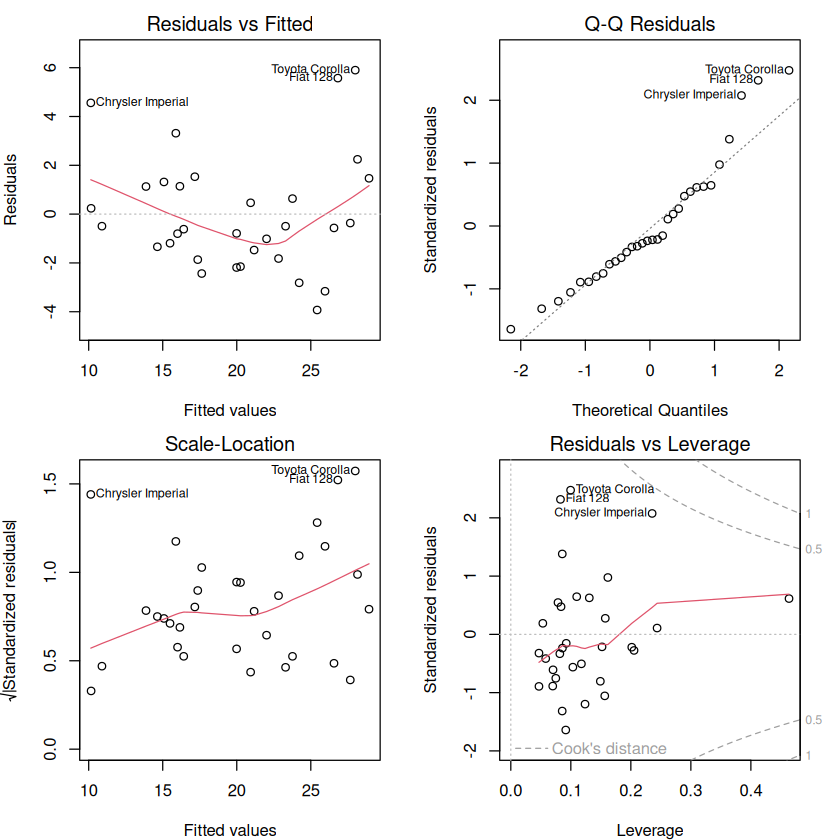

In [4]:
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(mod)

And compared them to the log-transformed model

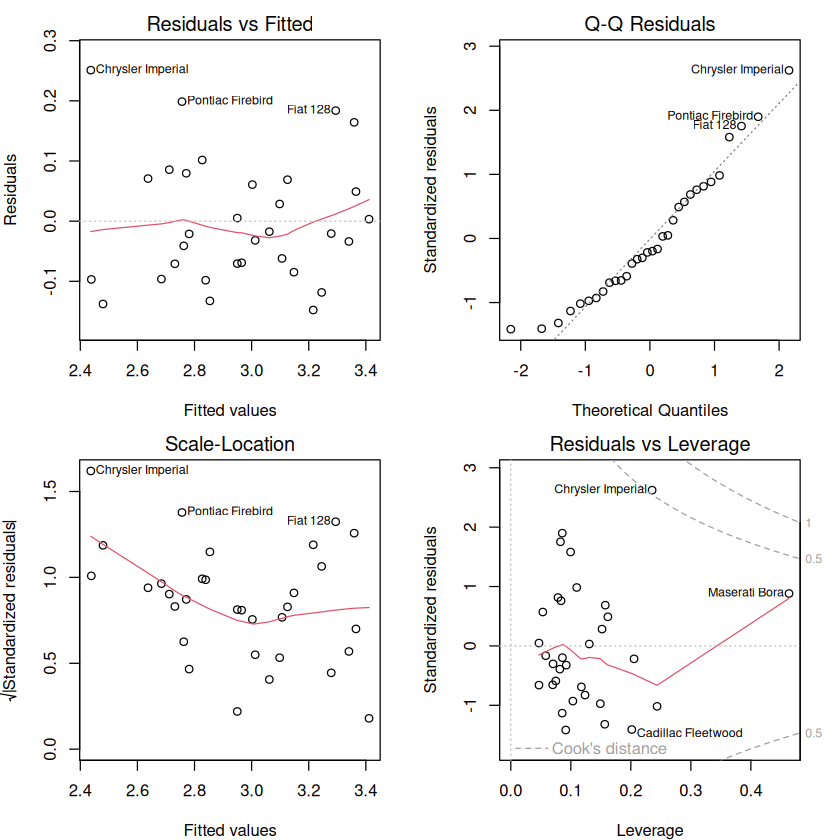

In [5]:
par(mfrow=c(2,2), mar=c(4,4,2,2))
plot(log.mod)

This does seem to have helped, particularly in terms of linearising the relationships in the data and bringing in some of the heavier tails of the residual distribution. We can see this improvement in fit by examining the effects plot for the transformed model.

In [6]:
options(warn=-1)

Loading required package: carData

lattice theme set by effectsTheme()
See ?effectsTheme for details.



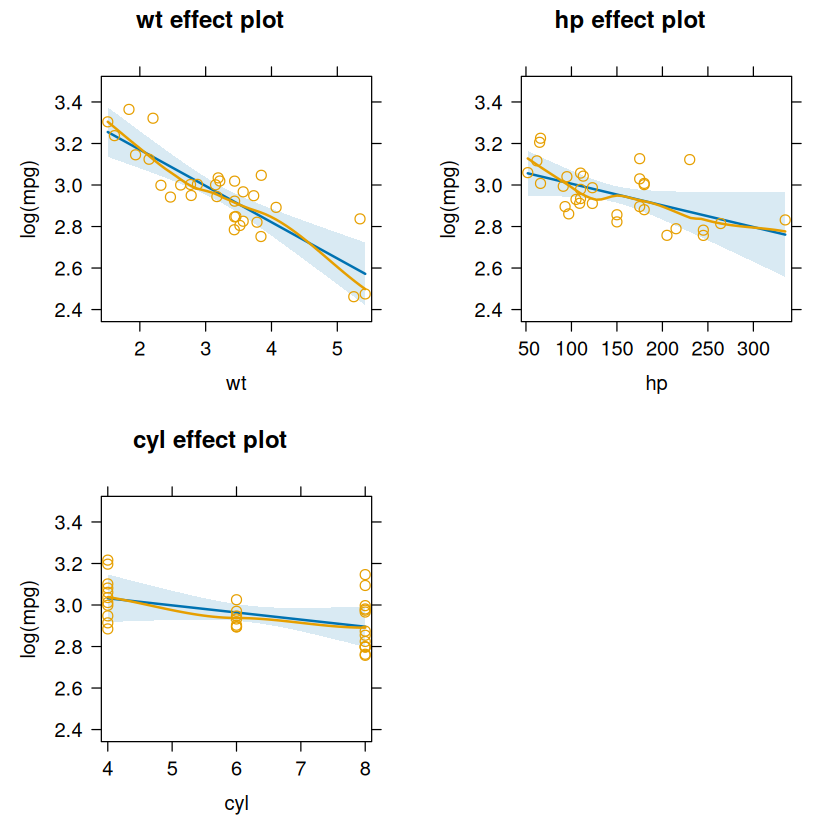

In [7]:
library(effects)
plot(allEffects(log.mod, residuals=TRUE))

Although this seems like a successful application of the Box-Cox method, we always need to take interpretation into account when dealing with transformations. The meaning of the regression coefficients has now changed as they correspond to how much the *log* of the outcome changes for a unit increase in each predictor. This might be harder to understand and could be enough to dissuade you from considering a transformations of the outcome, even if the model fit can be improved. As always, a decision must be made about whether to prioritise the model fit or interpretation. 

## Transforming the Predictors
As well as the outcome, we can also consider transformations applied to the predictors. Typically, these would be used to improve the model fit by either linearising certain relationships in the data, or to model those non-linearities directly. In other words, we can either try and *remove* any curved relationships so that a straight-line will work, or we can alter the regression model so that it *includes* curved relationships as part of its predictions. We will see examples of both below.

### Linearising Relationships
We start by examining methods that aim to *remove* any non-linearities in the relationship between the outcome and the predictor. We saw earlier how this can be achieved in part by transforming the outcome variable, though there were some issues with doing so, particularly around intepretation. As such, we may choose to instead transform the associated predictor variables. This can be more effective, particularly in the context of multiple regression, as different predictors may require different transformations depending upon the form of each relationship. Rather than transform the whole outcome, we can instead taylor the transformation to each predictor separately in a bid to remove any non-linearities from the data.

#### Box-Tidwell
As we saw earlier, we could spend some time guessing the appropriate transformations. However, this is not the most efficient approach. Instead, we can use a variant of the Box-Cox method designed for the *predictor* variables, known as the Box-Tidwell approach. Like Box-Cox, the transformations are defined in terms of raising predictor $j$ to the power of $\lambda_{j}$, where the values of $\lambda$ that best linearises the relationship can be found be MLE. 

As an example, the `boxTidwell()` function from the `car` package takes 3 inputs. The model formula, including those predictors that are candidates for transformation (i.e. `wt` and `hp`), a one-sided formula including those predictors that are *not* candidates for transformation but remain in the model (i.e. `cyl`), and the data.

In [8]:
library(car)
box.t <- boxTidwell(mpg ~ wt + hp, ~ cyl, data=mtcars)
print(box.t)

   MLE of lambda Score Statistic (z) Pr(>|z|)   
wt      -0.52177              2.6058 0.009165 **
hp      61.47640              2.1040 0.035382 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  26 


Here we can see that the value of each $\lambda_{j}$ that best linearises the relationships between each predictor and the outcome are found by MLE. The estimate of $\hat{\lambda}_{1} = -0.52$ seems reasonable. However, $\hat{\lambda}_{2} = 61.48$ is entirely implausible. As mentioned earlier, these methods are highly sensitive to outliers. As such, we can try running this function again using the `subset` argument to remove observations with studentised residuals greater than 2. 

In [9]:
resid.t      <- rstudent(lm(mpg ~ wt + hp + cyl, data=mtcars))
not.outliers <- abs(resid.t) < 2
box.t        <- boxTidwell(mpg ~ wt + hp, ~ cyl, data=mtcars, subset=not.outliers)
print(box.t)

   MLE of lambda Score Statistic (z) Pr(>|z|)  
wt     -0.058479              1.9374  0.05269 .
hp     -0.124602              1.3069  0.19124  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  6 


This seems much more reasonable. We can plug these results into the model as follows

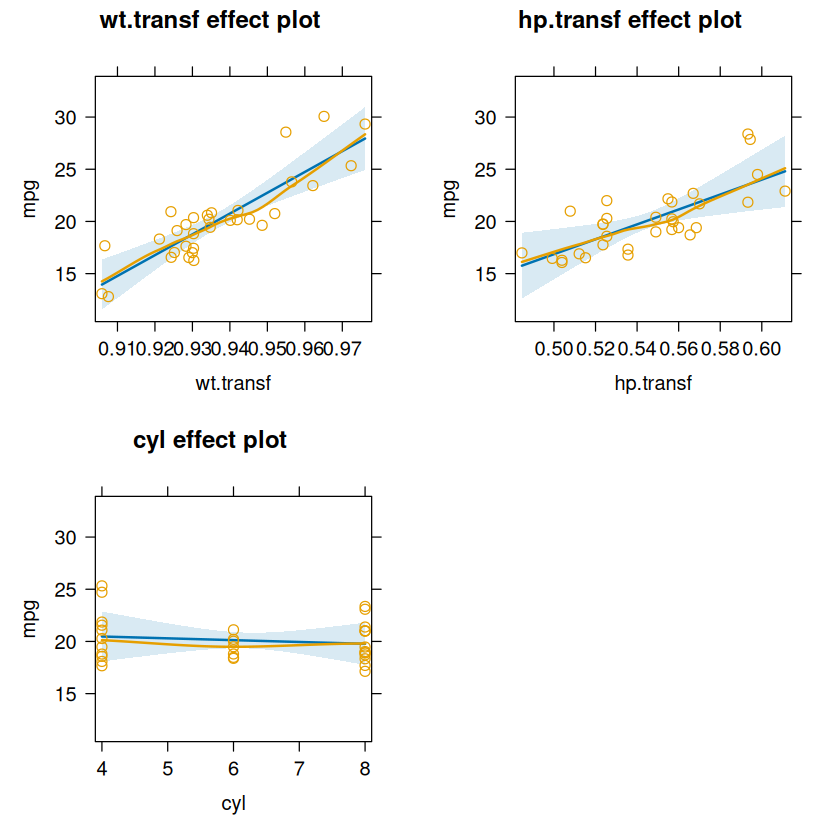

In [10]:
lambda    <- box.t$result
wt.transf <- mtcars$wt^lambda[1]
hp.transf <- mtcars$hp^lambda[2]
box.t.mod <- lm(mpg ~ wt.transf + hp.transf + cyl, data=mtcars)
plot(allEffects(box.t.mod, residuals=TRUE))

So this had done the job. However, we hit an interpretational issues becuase what exactly does $\frac{1}{\text{weight}^{0.06}}$ or $\frac{1}{\text{horsepower}^{0.12}}$ mean? Instead, we can see that both results from the Box-Tidwell method are quite close to 0, which would give us $\log{\text{weight}}$ and $\log{\text{horsepower}}$. We can try these instead and see what happens

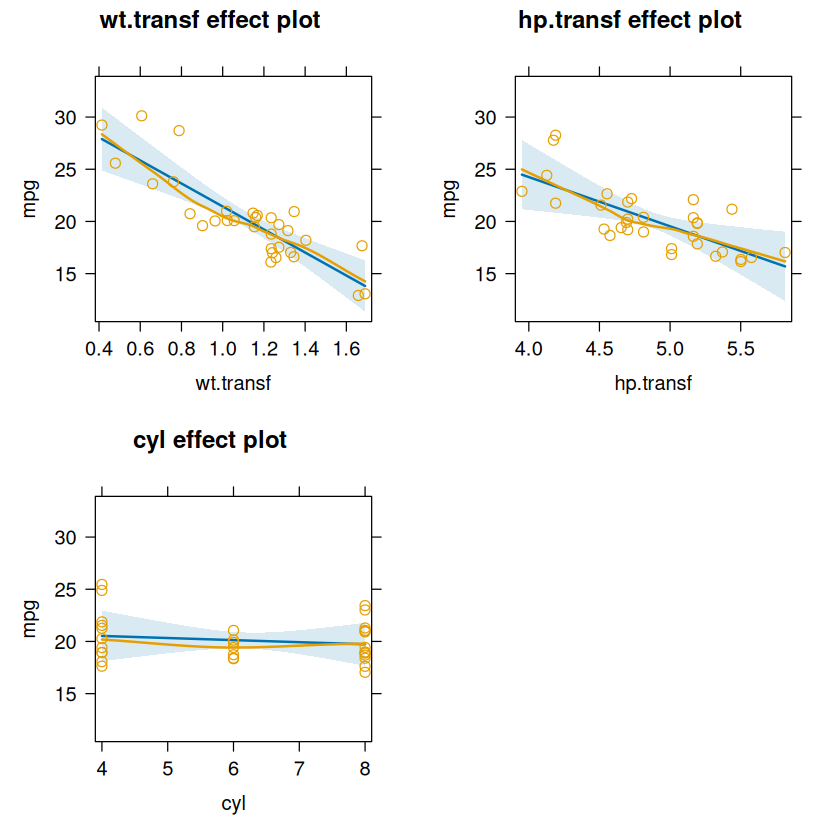

In [11]:
wt.transf  <- log(mtcars$wt)
hp.transf  <- log(mtcars$hp)
transf.mod <- lm(mpg ~ wt.transf + hp.transf + cyl, data=mtcars)
plot(allEffects(transf.mod, residuals=TRUE))

So the fit is very similar, but we have used transformations that are easier to interpret, particularly as we are not using the reciprocal of the variables and thus reversing the direction of the effects. Even if the exact Box-Tidwell results give us a better model fit, we may wish to compromise this for ease of interpretation. Again, this is a call that must be made by *you* as the data analyst.

#### Visualising Transforms Further
One of the more useful aspects of the `effects` package is that if the transformation is embedded in the model equation, it will be reverse when the effect is plotted and you can see the shape that is being *removed* from the data, on the original scale.  So, in these examples, think of the plot as showing the curve that is being *removed* in order to linearise the relationship and make a straight-line suitable. In the example below, we stick to the transforms derived from the Box-Tidwell method, but implement them within the model equation so that the `effects` package is aware of them. When we do this and plot the data, we can effectively see the shape of the relationship implied by the transformation. So these relationships are *linear* on the transformed scale and *non-linear* on their original scale.

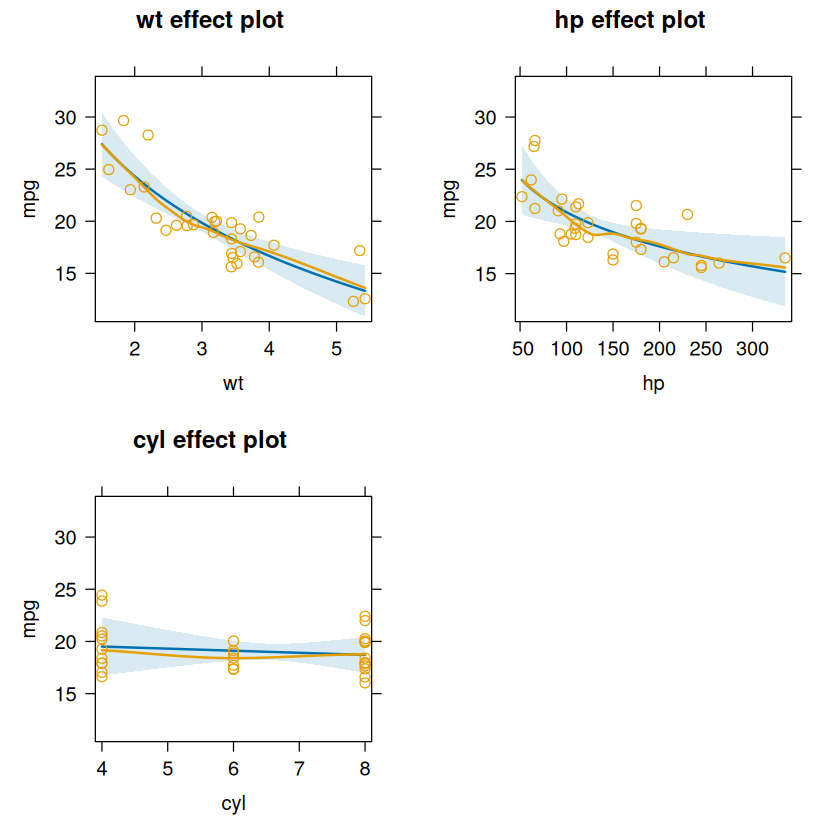

In [12]:
transf.mod <- lm(mpg ~ log(wt) + log(hp) + cyl, data=mtcars)
plot(allEffects(transf.mod, residuals=TRUE))

### Polynomial Regression
Although we can see how predictor transforms are able to help meet the assumptions of the regression model, doing so comes with a cost in terms of interpretation. Although we can make a straight-line work by turning $\text{weight} \rightarrow \frac{1}{\text{weight}^{0.06}}$, it might not be very clear what this *means*. Even a more standard transformation such as $\log\text{weight}$ comes with some conceptual burden in terms of trying to understand our model estimates on the log-scale. Thus, we can end up in a situation where the model fits very well, but we cannot explain any of the results.

An alternative, and often preferable approach, is not to change the predictors to suit the model. Instead, we change the model to suit the predictors. So, rather than trying to *remove* curvature from the data, we could instead *include* curvature in the model. This means that we do not change the predictors, instead we change the model by introducting a *function* of the predictors. The simplest way of doing this is to use a *polynomial* function of each predictor we want to model as a curved relationship.

A polynomial of degree $d$ is a function of a single predictor of the following form

$$
\begin{align*}
    \text{poly}_{d}\left(x_{i}\right)   &= \beta_{0}x_{i}^{0} + \beta_{1}x_{i}^{1} + \beta_{2}x_{i}^{2} + \cdots + \beta_{d}x_{i}^{d} \\
                                        &= \beta_{0} + \beta_{1}x_{i} + \sum_{p=2}^{d} \beta_{p}x_{i}^{p}.
\end{align*}
$$

Effectively, we just raise $x_{i}$ to as many powers as we like and then plug them into the regression equation. This fits a *curve* to the data, where the number of *bends* in the curve is controlled by the degree $d$. For $d > 0$, the curve of the line will have $d-1$ bends. For instance, a polynomial of $d=1$ is linear and fits a straight-line with $d-1 = 0$ bends. A polynomial of $d=2$ (known as a *quadratic* polynomial) fits a curved line with $d-1 = 1$ bend. A polynomial of $d=3$ (known as a *cubic* polynomial) fits a curved line with $d-1=2$ bends, and so on. The regression coefficients will then control the *direction* of the curve, as well as the *location* of the bends, allowing the prediction to flexibly bend upwards or downwards, depending upon the best fit to the data.

We can include polynomials in `R` using the `poly()` function. Looking at the plots of both `wt` and `hp`, they both look like there is a single bend in the relationship, which would imply a *quadratic* realationship using $d=2$. We can try this in `R` using.

In [13]:
poly.mod <- lm(mpg ~ poly(wt,degree=2) + poly(hp,degree=2) + cyl, data=mtcars)
summary(poly.mod)


Call:
lm(formula = mpg ~ poly(wt, degree = 2) + poly(hp, degree = 2) + 
    cyl, data = mtcars)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7956 -1.8425 -0.3851  1.4348  4.5607 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)            19.51609    3.61441   5.400 1.17e-05 ***
poly(wt, degree = 2)1 -18.70421    3.75554  -4.980 3.54e-05 ***
poly(wt, degree = 2)2   6.37935    2.36169   2.701  0.01200 *  
poly(hp, degree = 2)1 -13.63792    4.87670  -2.797  0.00959 ** 
poly(hp, degree = 2)2   5.67410    2.93010   1.936  0.06375 .  
cyl                     0.09285    0.58083   0.160  0.87422    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.174 on 26 degrees of freedom
Multiple R-squared:  0.8908,	Adjusted R-squared:  0.8698 
F-statistic: 42.43 on 5 and 26 DF,  p-value: 1.077e-11


Notice that the `poly()` function adds extra terms to the regression model in order to capture the assumed shape of the curve. Here, we can think of these as the linear and qudratic *components* of the curve[^poly-foot]. Note that this is one *disadvantage* of a polynomial model over a transformed model, as the polynomial adds extra terms meaning we lose error degrees of freedom. 

Like the transformed model, we can use the `effects` package to see the shape that has, this time, actually been fit to the data.

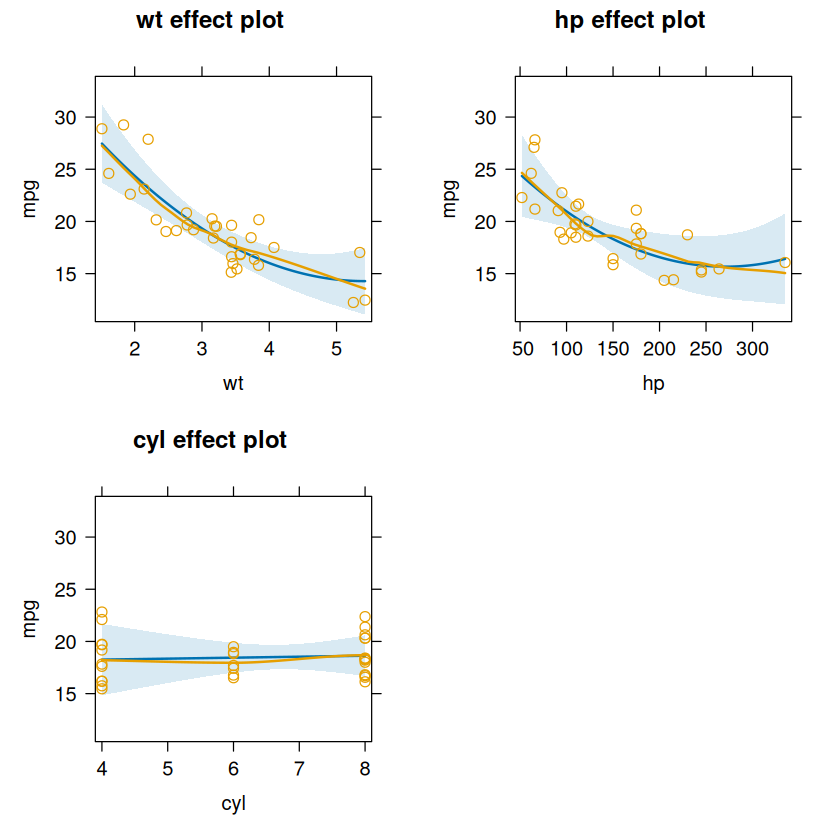

In [14]:
plot(allEffects(poly.mod, residuals=TRUE))

As in the case of transformations, the `effects` package is smart enough to combine the coefficients for the polynomial terms to show the fit for each variable. We could also try a higher-degree for `wt`, if we believed that 3 bends would best capture this relationship.


Call:
lm(formula = mpg ~ poly(wt, degree = 3) + poly(hp, degree = 2) + 
    cyl, data = mtcars)

Residuals:
   Min     1Q Median     3Q    Max 
-2.624 -1.450 -0.274  1.062  5.042 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)            21.7394     3.9911   5.447 1.18e-05 ***
poly(wt, degree = 3)1 -16.6136     4.0721  -4.080 0.000403 ***
poly(wt, degree = 3)2   5.6993     2.3983   2.376 0.025458 *  
poly(wt, degree = 3)3  -3.1619     2.5224  -1.254 0.221617    
poly(hp, degree = 2)1 -12.7539     4.8753  -2.616 0.014870 *  
poly(hp, degree = 2)2   5.3497     2.9100   1.838 0.077913 .  
cyl                    -0.2665     0.6421  -0.415 0.681683    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.151 on 25 degrees of freedom
Multiple R-squared:  0.8973,	Adjusted R-squared:  0.8726 
F-statistic:  36.4 on 6 and 25 DF,  p-value: 3.54e-11


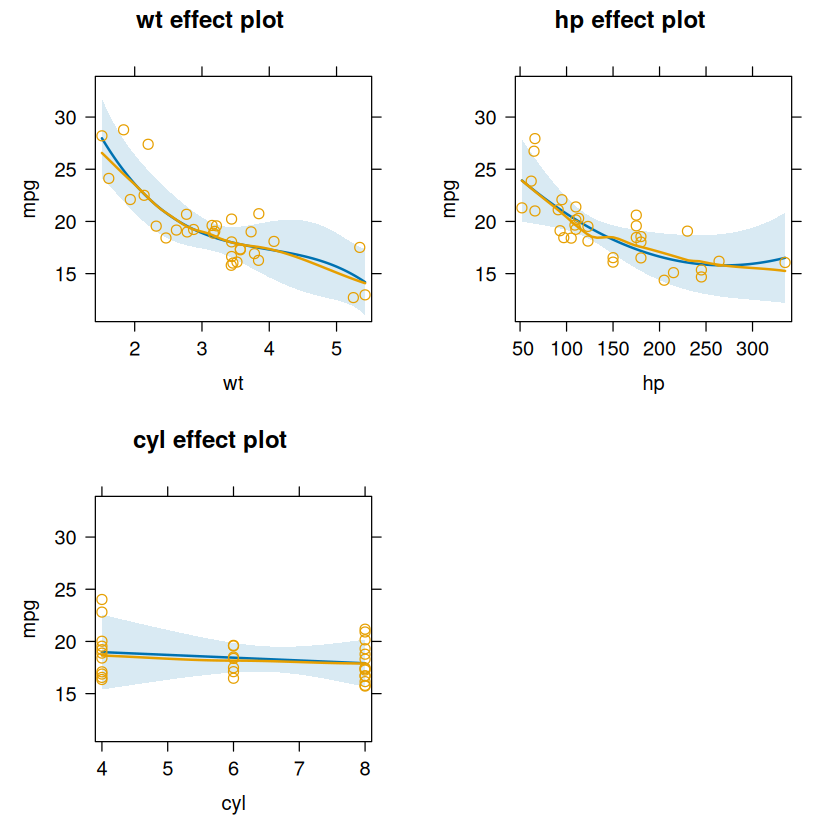

In [15]:
poly.mod <- lm(mpg ~ poly(wt,degree=3) + poly(hp,degree=2) + cyl, data=mtcars)
summary(poly.mod)
plot(allEffects(poly.mod, residuals=TRUE))

There is now an extra wiggle in the fitted relationship between `wt` and `mpg`, governed by the additional model term. However, we can see that this component is not significant and thus may not be adding anything useful to the model. This would appear to be supported by the visualisation. In general, we would not recommend fitting shapes with $d > 4$ to keep the models simpler, keep interpretation easier and to reduce the risk of the shape being governed more by the noise in the data (an issue known as *overfitting*).

## Standardised Regression
A final use for transformation in a regression model is less about improving the model fit and more about aiding *interpretation* of the regression model. One particular issue with the regression models we have seen so far is that their interpretation depends entirely upon the scale of both the outcome variable and each individual predictor variable. Remember that a regression coefficient can be interpreted as the change in the outcome for a unit change in the predictor. This has several consequences for interpretation:

- Interpreting the magnitude of change in the outcome requires understanding the scale upon which the outcome is measured
- Interpreting a unit change in a predictor requires understanding the scale upon which the predictor is measured
- Because the coefficient is tied to the scale of the predictor, we cannot compare the magnitude of the coefficients across different predictors in any meaningful way

For variables that are well characterised on a scale that is well-understood, perhaps with some known normative data, these values can be meaningfully interpreted. However, as is often the case in Experimental Psychology, if the variables in question are not well-characterised and do not have easily interpretable units, then we face a problem in interpreting the regression coefficients. Furthermore, if we want some sense of where the *biggest* relationships lie, we have no means of comparing the coefficients to each other.

The solution in these situations is to use *standardised regression*. This is a form of transformation where both the outcome and the predictors are re-scaled into units of standard deviations (sometimes known as $z$-scores). This is achieved by subtracting the mean from each datapoint and then dividing by the standard deviation 

$$
x^{(z)}_{i} = \frac{x_{i} - \bar{x}}{\text{SD}\left\{x\right\}}.
$$

This can be computer either manually in `R`, or by using the built-in `scale()` function. Using the re-scaled variables then leads to a regression model that can be interpreted in terms of the change in the outcome on the standard deviation scale after 1 standard deviation change in each predictor. Furthermore, because all the predictors are now on the same scale, we can compared their magnitudes in a meaningful way.

As an example, we can fit a standardised version of our `mtcars` model. Notice that standardisation will always render the intercept 0, so it can be removed from the model by adding `-1` to the model formula.

In [16]:
mpg.z <- scale(mtcars$mpg)
wt.z  <- scale(mtcars$wt)
hp.z  <- scale(mtcars$hp)
cyl.z <- scale(mtcars$cyl)
mod.z <- lm(mpg.z ~ wt.z + hp.z + cyl.z -1)
summary(mod.z)


Call:
lm(formula = mpg.z ~ wt.z + hp.z + cyl.z - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.65191 -0.25880 -0.08813  0.19662  0.97870 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
wt.z   -0.5141     0.1181  -4.352 0.000153 ***
hp.z   -0.2052     0.1328  -1.546 0.133016    
cyl.z  -0.2790     0.1604  -1.739 0.092564 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4095 on 29 degrees of freedom
Multiple R-squared:  0.8431,	Adjusted R-squared:  0.8269 
F-statistic: 51.96 on 3 and 29 DF,  p-value: 8.794e-12


We can now interpet the standardised model. To begin with, we can rank the effects in terms of the magnitude of their coefficients. `wt` has the largest effect, followed by `cyl` and then `hp`. In this way, standardisation gives a useful form of *effect size* that can be used to intepret the model more clearly. In terms of the individual coefficients, we can now interpret each on the scale of standard deviation. For instance, the `wt` effect of $\hat{\beta}_{1} = -0.51$ indicates that an increase of 1 standard deviation of `wt` results in a reduction in `mpg` of $0.51$ standard deviations. If we want to, we can then classify the magnitude of this effect using Cohen's guidelines of 0.10-0.29 being *small*, 0.30-0.49 are *medium*, and 0.50 or greater are *large*. So, in the model above, we have one *large* effect and two *small* effects. Though note that such *trichotomisation* of evidence is not much better than binarising results into *significant* and *non-significant*. 

## What if Nothing Works?
As we have discussed throughout this section, beyond standardised regression, the main aim of all of these transformations has been to make the model more suitable for the data, or the data more suitable for the model. In doing so, the aim is that the regression assumptions are also better met. However, the reality is often not this simple. Real data are often very messy and sometimes you can try all the tricks above and still end up with a model where the assumptions are not well-met. Often, this comes down to using inappropriate data. For instance, results from a questionnaire where the outcome can only take a set number of integer values. Although we want to treat this as continuous, it is not really and it may be unlikely that we will ever get the regression model to fit that well.

As an example, if we instead wanted to use `cyl` as our outcome variable[^cyl-foot], we would have

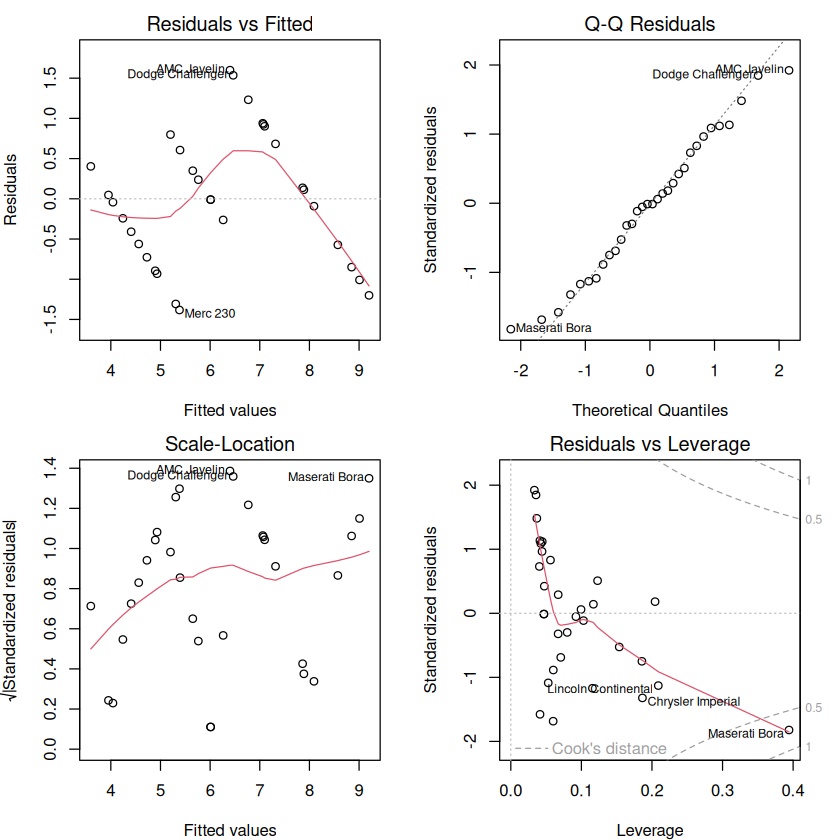

In [17]:
data(mtcars)
cyl.mod <- lm(cyl ~ hp + wt, data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2)) # 2x2 grid with tighter margins
plot(cyl.mod)

Take a moment to look at these plots and think about which ones look OK and which ones look strange. Much of this strangeness is because `cyl` only has a small number of possible values. We can see this by using the `unique()` function

In [18]:
print(unique(mtcars$cyl))

[1] 6 4 8


So, we have an outcome variable that only takes on 3 unique values. This is closer to being a *categorical* outcome than a continuous outcome. We may think we can get around this with some transformations.

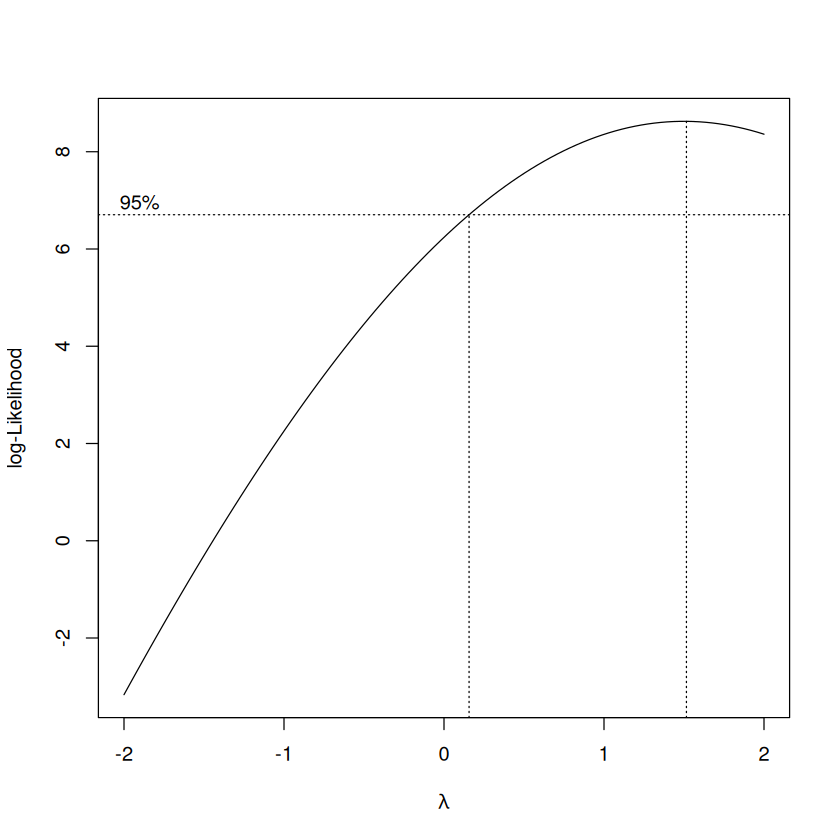

In [19]:
library(MASS)
boxcox(cyl.mod)

This looks close to a value of $\lambda=\frac{1}{2}$, indicating a *square-root* transformation. We can try this.

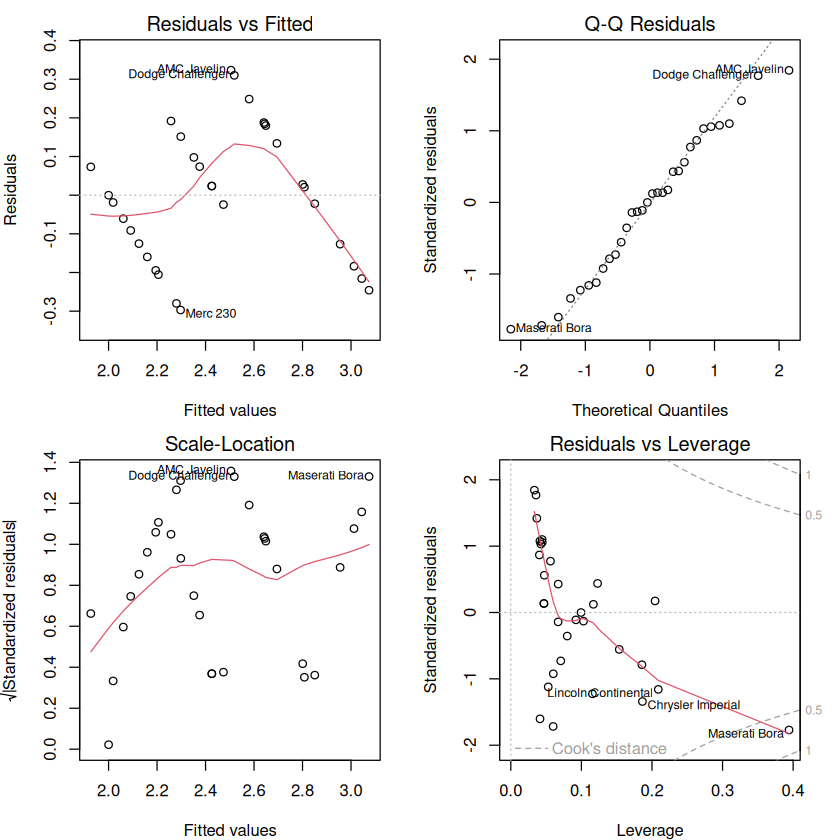

In [20]:
cyl.mod.sqrt <- lm(sqrt(cyl) ~ hp + wt, data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2)) # 2x2 grid with tighter margins
plot(cyl.mod.sqrt)

which does not seem to have done very much. If we examine the effects plots

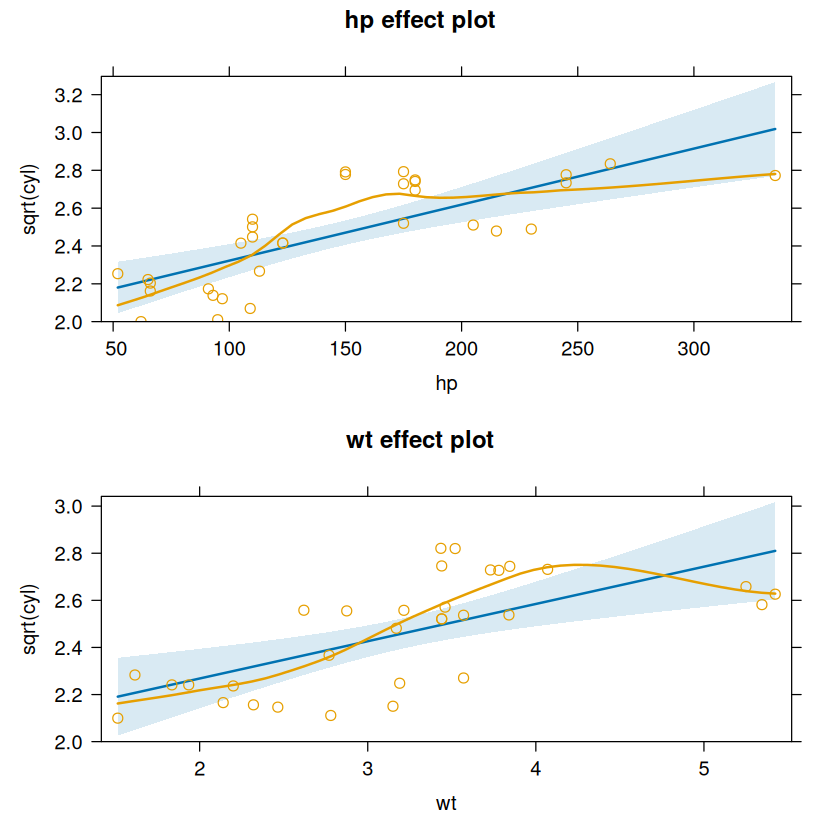

In [21]:
library(effects)
plot(allEffects(cyl.mod.sqrt, residuals=TRUE), rows=2, cols=1)

we can see some potential non-linearities. We could look at Box-Tidwell options here (after excluding outliers)[^iter-foot]

In [22]:
resid.t      <- rstudent(lm(sqrt(cyl) ~ hp + wt, data=mtcars))
not.outliers <- abs(resid.t) < 2
box.t        <- boxTidwell(sqrt(cyl) ~ hp + wt, data=mtcars, subset=not.outliers, max.iter=50)
print(box.t)

   MLE of lambda Score Statistic (z) Pr(>|z|)  
hp     0.0027772             -2.5747  0.01003 *
wt    -0.0544542             -1.3485  0.17749  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  34 


As both of these values are quite close to 0, it suggests that the log of both variables could be an improvement

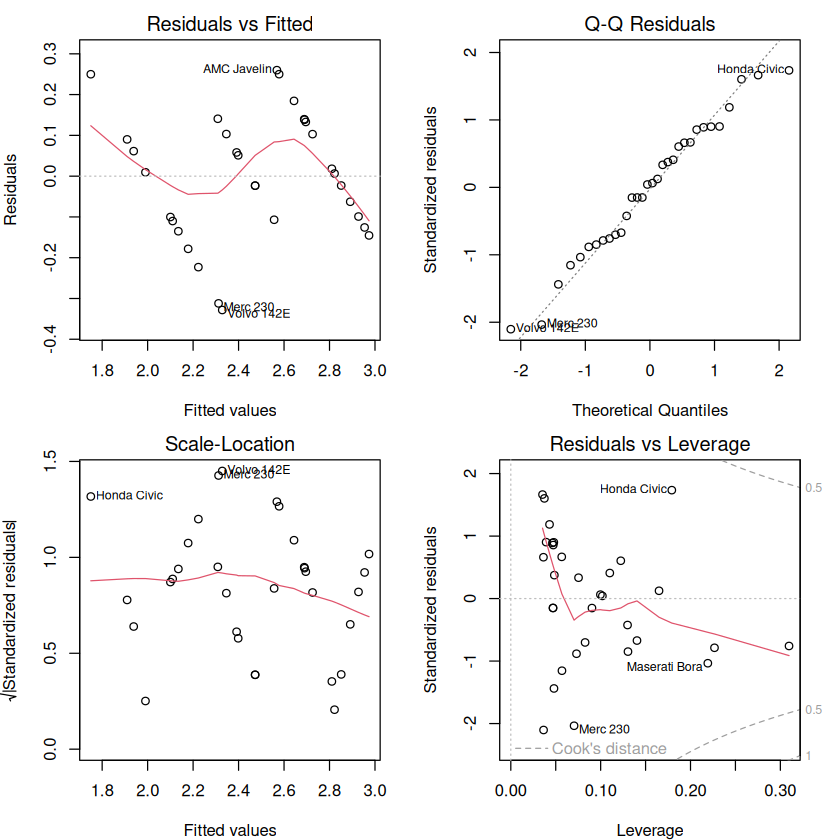

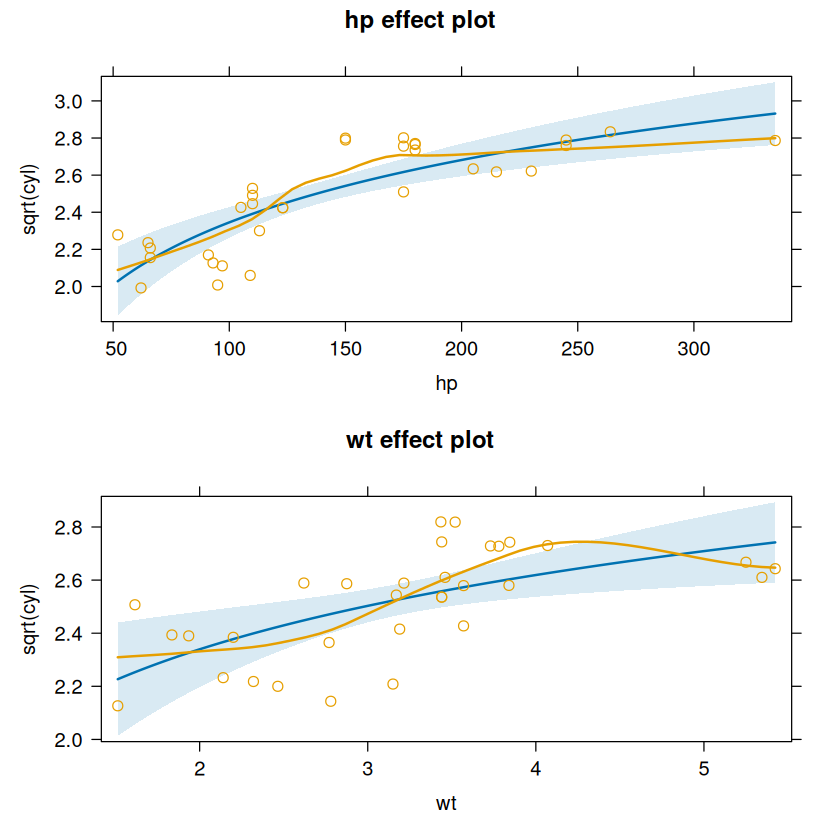

In [23]:
cyl.mod.log <- lm(sqrt(cyl) ~ log(hp) + log(wt), data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2)) # 2x2 grid with tighter margins
plot(cyl.mod.log)
plot(allEffects(cyl.mod.log, residuals=TRUE), rows=2, cols=1)

This has perhaps helped a little? We could instead try some polynomials. As the curve shown in the effects plot for `hp` has a single prominant bend, we can try $d=2$, whereas the plot for `wt` has two bends, so we can try $d=3$.

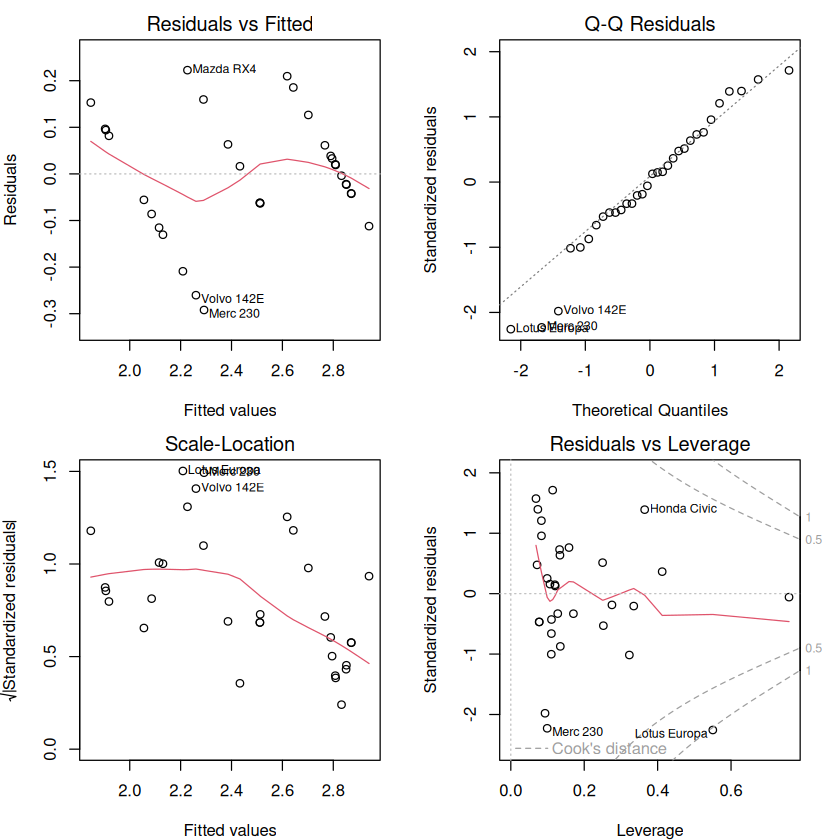

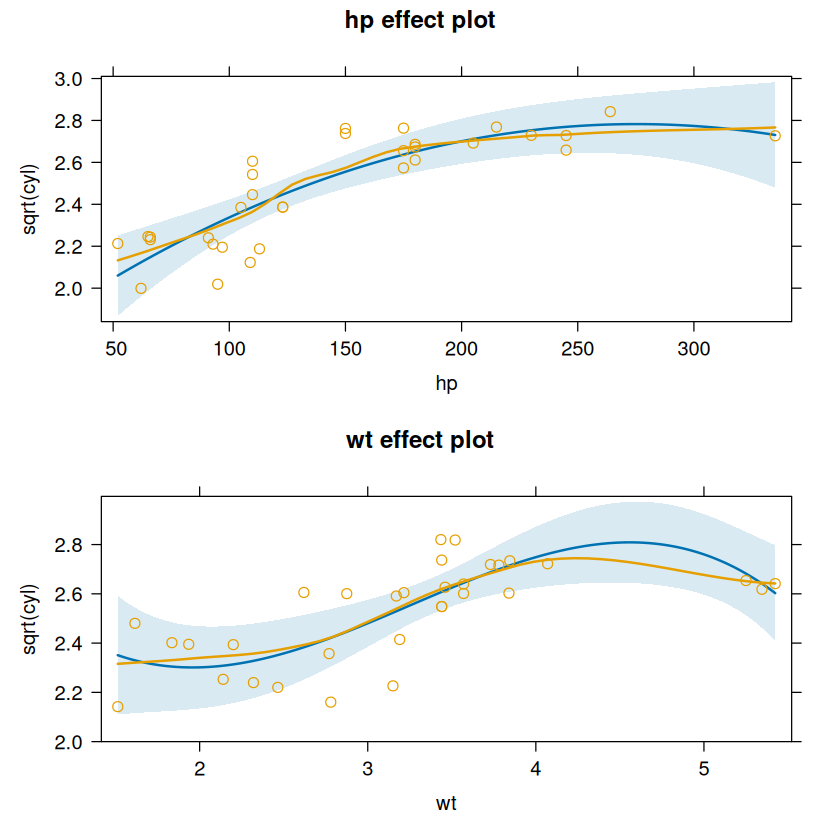

In [24]:
cyl.mod.poly <- lm(sqrt(cyl) ~ poly(hp, degree=2) + poly(wt, degree=3), data=mtcars)
par(mfrow=c(2,2), mar=c(4,4,2,2)) # 2x2 grid with tighter margins
plot(cyl.mod.poly)
plot(allEffects(cyl.mod.poly, residuals=TRUE), rows=2, cols=1)

This is likely the best we can do with our current set of tools. However, even ignoring all the problems with interpretation we now have, both the Residuals vs Fitted and the Scale-Location plots do not look great. The QQ-normal plot also suggests quite an extreme heavy tail at the lower-end of the distribution.

So what would we do in this situation? We really only have a few choices

1. Accept that this is the best that we can do, be honest when reporting the model and treat the inference with caution
2. Stick with multiple regression, but look for alternative estimation techniques that allow us to lift some of the regression assumptions
3. Abandon multiple regression and look for an alternative modelling framework that allows a more flexible fit to this type of data (e.g. Generalised Linear Models).

For our current purposes, we are sticking with the multiple regression framework, meaning that we either choose option 1 or option 2. Although option 1 is perfectly legitimate, it can feel unsatisfying. However, we need to accept that no model will ever be perfect and that to strive for this is a fools' errand. We also need to realise that this is precisely what goes on in the literature all the time. The only difference is that it is often obfuscated by either not mentioning the assumptions, waving them to one side by stating that the assumptions were "adequately met", or calling upon something like the central limit theorem[^clt-foot]. If we wish to be honest, we need to simply state that some potential issues remain with the model assumptions and thus inference will be treated cautiously. In cases where $p$-values are very small, we probably do not need to worry. However, if we get $p = 0.048$ or $p = 0.056$, then much more cautious interpretation is needed. In addition, it is worth remembering that many of these assumptions only really matter for the calculation of $p$-values, so we can happily continue interpreting the regression coefficients, even in the absence of a condition such as normality.

In terms of option 2, there are various ways that the regression model can be adjusted in cases of outliers (*robust regression*), heteroscedasticity (*generalised least squares*), multicollinearity (*ridge regression*) and non-normality (*non-parametric resampling*). None of these methods are a panacea, and our ability to combine them in cases where multiple assumptions are not met can be very limited. However, they can be used to help in certain situations. We will examine all of these in more detail in our next synchronous session.

`````{topic} What do you now know?
In this section, we have explored variable transformations as a means of improving the model fit, the model assumptions and the interpretability of the model. After reading this section, you should have a good sense of:

- The concept of changing the outcome variable using some form of monotonic transformation.
- The Box-Cox method as an automated way of finding the transformation that leads to the best-fitting model by raising the outcome to some exponent $\lambda$.
- The idea that Box-Cox can lead to transformations that are difficult to interpret, meaning often we would choose the most interpretable transformation that is *closest* to the estimated value of $\lambda$.
- The concept of transforming the predictors in a similar fashion, usually as a means of *linearising* the relationships in the data.
- The method of Box-Tidwell, that finds the best linearising transforming by raising predictor $j$ to the power $\lambda_{j}$.
- Polynomial regression as an alternative method that *adds* non-linear modelling to the regression framework, rather than *removing* non-linearities.
- Standardised regression as a method of improving the interpretation of regression coefficients by placing them all on the standard deviation scale.
- The idea that despite all these options, sometimes they will not work. In those cases, we either accept that the model fit will be limited, or look to other methods that lift some of the regression assumptions.
`````

[^poly-foot]: This is only because the `poly()` function constructs what are known as *orthogonal* polynomials. This will not be the same as fitting a model using `mpg ~ wt + I(wt^2) + hp + I(hp^2) + cyl`.

[^cyl-foot]: This does not make much sense in terms of a predictive model as it is difficult to imagine why we would want to predict the number of cylinders from the weight and horsepower of a car. However, it is a useful example because of the nature of the `cyl` variable.

[^clt-foot]: Note that in large datasets, the central limit theorem will apply and so this is a legitimate point to raise. However, we then have the fundamental issue with NHST that large samples will render meaningless effects significant. The gods of statistics giveth and they taketh away.

[^iter-foot]: The Box-Tidwell algorithm does not converge here after the default number of iterations, so we have increased them in this example. Usually, you just increase until the warning message goes away.